In [1]:
import os, sys, obspy
import numpy as np
import matplotlib.pyplot as plt
import pickle
LIBpath = os.path.join( os.getenv('HOME'),'src','kitchensinkGT', 'LIB')
sys.path.append(LIBpath)
from libseisGT import inventory2traceid, get_FDSN_inventory, clean_trace, \
    attach_station_coordinates_from_inventory
from obspy.clients.fdsn import Client
#from obspy.core.util import AttribDict
from obspy.geodetics import locations2degrees, degrees2kilometers

def get_fdsn_identifier(fdsnURL):
    prepend=''
    if 'iris' in fdsnURL:
        prepend='iris_'
    if 'shake' in fdsnURL:
        prepend='rboom_'
    if 'geonet' in fdsnURL:
        prepend='nz_'  
    return prepend

def get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, olat, olon, startt, endt, chanstring, data_root, overwrite=False):
    fdsnClient = Client(fdsnURL)  
    if not os.path.isdir(data_root):
        print('No such directory %s' % data_root)
        return None, None
    
    # STEP 1 - FIND STATIONS BY REQUESTING AN INVENTORY
    prepend = get_fdsn_identifier(fdsnURL)
    stationXmlFile = os.path.join(data_root, '%s%s_within_%.0f_degrees.xml' % (prepend, chanstring, searchRadiusDeg))
    mseedfile = stationXmlFile.replace('.xml','.mseed')
    print(stationXmlFile, mseedfile)
    
    if os.path.exists(stationXmlFile) and overwrite==False:
        inv = obspy.read_inventory(stationXmlFile)
    else:
        inv = get_FDSN_inventory(fdsnClient, startt, stationXmlFile, '*', olat, olon, \
            searchRadiusDeg, 0, endt - startt, channel = chanstring ) # get all low rate, outside barometers
    trace_ids = inventory2traceid(inv)
    print(trace_ids)
    
    # STEP 2 - LOAD CORRESPONDING WAVEFORM DATA
    if os.path.exists(mseedfile) and overwrite==False:
        st = obspy.core.read(mseedfile)
    else:
        st = obspy.core.Stream()
        for trace_id in trace_ids:
            try:
                net, sta, loc, cha = trace_id.split('.')
            except:
                net, sta, cha = trace_id.split('.')
                loc = '*'
            try:
                st0 = fdsnClient.get_waveforms(net, sta, loc, cha, startt, endt)
                print('waveform downloaded for ', trace_id)
                if len(st0)==1:
                    st.append(st0[0])
                else:
                    print('More than 1 Trace')
                    last_id = ''
                    for tr0 in st0:
                        if tr0.id != last_id:
                            st.append(tr0)
                        else:
                            st.remove(st[-1])
            except:
                print('failed to download waveform for ', trace_id)
            
        # save waveform data
        if len(st)>0:
            st.write(stationXmlFile.replace('.xml','.mseed'))
        
    return st, inv

def reconstitute_stream(st, inv, fmin=0.0001):
    T=1.0/fmin
    
    # deal with multiple traces with same trace ID, by appending and merging one at a time,
    # and removing any time there is a fail.
    st2 = obspy.core.Stream()
    for tr_original in st:
        tr = tr_original.copy()
        st2 = st2.append(tr)
        try:
            st2.merge(method=1, fill_value=0)
        except:
            st2.remove(tr)
            pass
        
    # reconstitute as many traces as possible, and return them
    reconstituted = obspy.core.Stream()
    failed_ids = []
    for tr_original in st2:
        tr = tr_original.copy()
        
        # remove gappy Trace objects, filled with 0 above (threshold 10%)
        n = np.count_nonzero(tr.data==0)
        if n/len(tr.data) > 0.1:
            st2.remove(tr_original)
            continue
            
        # high pass filter    
        tr.detrend('linear')
        duration = tr.stats.endtime - tr.stats.starttime
        tr.taper(T/duration)
        tr.stats['maxamp_raw'] = np.max(np.abs(tr.data))
        tr.filter("highpass", freq=fmin, corners=2)
        
        # remove response
        try:
            tr.remove_response(inventory=inv)
            reconstituted.append(tr)
            #print(tr.id, ' reconstituted')
        except:
            #print(tr.id, ' NOT reconstituted')
            failed_ids.append(tr.id)
            pass
        tr.detrend('linear')
        tr.stats['maxamp_corrected'] = np.max(np.abs(tr.data))
    print('Failed to reconstitute: ', failed_ids)

    #reconstituted.plot(equal_scale=True);
    
    return reconstituted


def attach_station_coordinates_from_inventory(inventory, st):
    """ attach_station_coordinates_from_inventory """
    for tr in st:
        for netw in inventory.networks:
            for sta in netw.stations:
                if tr.stats.station == sta.code and netw.code == tr.stats.network:
                    for cha in sta.channels:
                        if tr.stats.location == cha.location_code:
                            tr.stats.coordinates = obspy.core.util.AttribDict({
                                'latitude':cha.latitude,
                                'longitude':cha.longitude,
                                'elevation':cha.elevation})
                            
def attach_distance_to_stream(st, olat, olon):
    for tr in st:
        try:
            alat = tr.stats['coordinates']['latitude']
            alon = tr.stats['coordinates']['longitude']
            distdeg = locations2degrees(olat, olon, alat, alon)
            distkm = degrees2kilometers(distdeg)
            tr.stats['distance'] =  distkm * 1000
        except:
            print('cannot compute distance for %s' % tr.id)
            
def remove_outliers(a, f=100):
    m = np.median(a)
    bad_indices = []
    for i, v in enumerate(a):
        if v > m * f:
            bad_indices.append(i)
        if v * f < m:
            bad_indices.append(i)            
    #print(bad_indices)
    if len(bad_indices)>0:
        for i in bad_indices:
            a[i]=np.NaN 
    return a
    
def plot_amplitude_versus_distance(st, units):
    r = []
    a = []
    for tr in st:
        r.append(tr.stats.distance)
        #a.append(tr.stats.maxamp_corrected)
        a.append(np.max(np.abs(tr.data)))
    remove_outliers(a, f=10)     
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(r/1000, a)
    ax.set_ylabel('Maximum amplitude (%s)' % units)
    ax.set_xlabel('Distance (km)')
    plt.show()
    
def plot_reduced_pressure(st, units):
    r = []
    a = []
    for tr in st:
        r.append(tr.stats.distance)
        #a.append(tr.stats.maxamp_corrected * np.sqrt(tr.stats.distance_in_km))
        a.append(np.max(np.abs(tr.data))* np.sqrt(tr.stats.distance_in_km))
    remove_outliers(a, f=10)    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(r/1000, a)
    ax.set_ylabel('Reduced Pressure (%s)' % units)
    ax.set_xlabel('Distance (km)')
    plt.show()
    
def yes_or_no(question):
    while "the answer is invalid":
        reply = str(input(question+' (y/n): ')).lower().strip()
        if reply[:1] == 'y':
            return True
        if reply[:1] == 'n':
            return False
        
def manually_select_good_traces(st, trim_mins=30):
    stkeep = obspy.core.Stream()
    for tr in st:
        startt = tr.stats.starttime + trim_mins * 60
        endt = tr.stats.endtime - trim_mins + 60      
        if endt > startt:
            tr.trim(starttime=startt, endtime=endt)
            tr.plot()
            print('max = ', np.max(np.abs(tr.data)))
            if yes_or_no('keep this trace? '):
                stkeep.append(tr.copy())
    return stkeep

def select_previously_manually_selected_traces(st, good_ids):
    stkeep = obspy.core.Stream()
    for tr in st:
        if tr.id in good_ids:
            stkeep.append(tr.copy())
    return stkeep

def analyze_clientchan(fdsnClient, chanstring, fmin=0.001):
    T = np.round(1/fmin,0)
    
    this_stream, this_inventory = get_inventory_and_waveforms(fdsnClient, searchRadiusDeg, olat, olon, startt, endt, chanstring, DATA_ROOT, overwrite=False)

    prepend = get_fdsn_identifier(fdsnClient)
    this_reconstituted = reconstitute_stream(this_stream, this_inventory, fmin=fmin)
    reconfile = os.path.join(DATA_ROOT, '%s%s_reconstituted_%.0f.mseed' % (prepend, chanstring, T))    
    #if chanstring[0]!='L':
    #    median_downsample_to_1Hz(this_reconstituted)
    #    reconfile = os.path.join(DATA_ROOT, '%s%s_reconstituted_%.0f_downsampled.mseed' % (prepend, chanstring, T))
    if not os.path.exists(reconfile):
        this_reconstituted.write(reconfile)
    
    good_ids_pickle = os.path.join(DATA_ROOT, '%sgood_%s_ids_within_%.0f_degrees.pkl' % (prepend, chanstring, searchRadiusDeg))
    if os.path.exists(good_ids_pickle):
        with open(good_ids_pickle, 'rb') as f:
            good_ids = pickle.load(f)        
        this_good = select_previously_manually_selected_traces(this_reconstituted, good_ids)
    else:
        this_good = manually_select_good_traces(this_reconstituted)
        good_ids = []
        for tr in this_good:
            good_ids.append(tr.id)
        print(good_ids)
        print(len(good_ids))
        with open(good_ids_pickle, 'wb') as f:
            pickle.dump(good_ids, f)    
        this_good.write(os.path.join(DATA_ROOT, '%s%s_good.mseed' % (prepend, chanstring)))   
        
    attach_station_coordinates_from_inventory(this_inventory, this_good)
    attach_distance_to_stream(this_good, olat, olon)

    this_trimmed = this_good.copy()
    this_trimmed.trim(starttime=startt+T, endtime=startt+T+18*3600) # just examine first pulse
    
    plot_amplitude_versus_distance(this_trimmed, 'Pa')
    plot_reduced_pressure(this_trimmed, 'Pa')
    
    good_inv = subset_inv(this_inventory, this_stream, this_good)
    plot_inv(good_inv)
    
    return this_good, good_inv

def subset_inv(inv, st, st_subset):
    # subset an inventory based on a stream object which is a subset of another
    try:
        inv_new = inv.copy() # got an error here once that Inventory has no copy(), but it does
        for tr in st:
            if len(st_subset.select(id=tr.id))==0:
                inv_new = inv_new.remove(network=tr.stats.network, station=tr.stats.station, location=tr.stats.location, channel=tr.stats.channel)
        return inv_new
    except:
        print('Failed to subset inventory. Returning unchanged')
        return inv

def plot_inv(inv):
    inv.plot(water_fill_color=[0.0, 0.5, 0.8], continent_fill_color=[0.1, 0.6, 0.1], size=30);
    
def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median(y, axis=1)


def median_downsample_to_1Hz(st, winlec_sec=1.0):
    for tr in st:
        y = medfilt(tr.data, np.round(winlen_secs / tr.stats.delta,0) )
        fs = np.round(tr.stats.sampling_rate,0)
        if fs>=2.0:
            fs_new = tr.stats.sampling_rate/fs
            tr.data = y[0::fs]
            tr.stats.sampling_rate=fs_new

In [2]:
DATA_ROOT = os.path.join(os.getenv('HOME'), 'DATA', 'Tonga_eruption_analysis')
if not os.path.isdir(DATA_ROOT):
    os.makedirs(DATA_ROOT)
searchRadiusDeg = 180
fmin = 0.0001
T = 1.0/fmin

# location of Hunga-Tonga Hunga-Ha'apai
olat = -(20 + 34/60 + 12 /3600) 
olon = -(175 + 22/60 + 48/3600)
otime = obspy.core.UTCDateTime('2022-01-15T04:14:45.000000Z') # main eruption time - on day 2

startt =  obspy.core.UTCDateTime('2022-01-13T00:00:00.000000Z') - T*2
endt = obspy.core.UTCDateTime('2022-01-20T00:00:00.000000Z') + T*2 # get 34 hours of data, since this is approximate time for sound waves to circle the earth        

fdsnURL = "http://service.iris.edu"
#chanstring = 'LDF'
fdsnClient = Client(fdsnURL)  
startt = otime-10000
endt = obspy.UTCDateTime(2022,1,15,7,0,0)+10000

msvf = fdsnClient.get_waveforms('II', 'MSVF', '*', '*', startt, endt)

In [3]:
print(msvf)

33 Trace(s) in Stream:

II.MSVF.00.BH1 | 2022-01-15T01:28:05.019539Z - 2022-01-15T09:46:39.969539Z | 20.0 Hz, 598300 samples
...
(31 other traces)
...
II.MSVF.10.VMW | 2022-01-15T01:28:10.000000Z - 2022-01-15T09:46:40.000000Z | 0.1 Hz, 2992 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


II.MSVF.00.LDI 2.50904153762e+17
II.MSVF.00.LDO 2.52645096058e+17
II.MSVF.00.LH1 1.73553749986e+13
II.MSVF.00.LH2 5.69128545875e+13
II.MSVF.00.LHZ 3.30409169742e+12
II.MSVF.10.LH1 1.58287588924e+16
II.MSVF.10.LH2 2.81285273704e+16
II.MSVF.10.LHZ 3.15944228995e+12


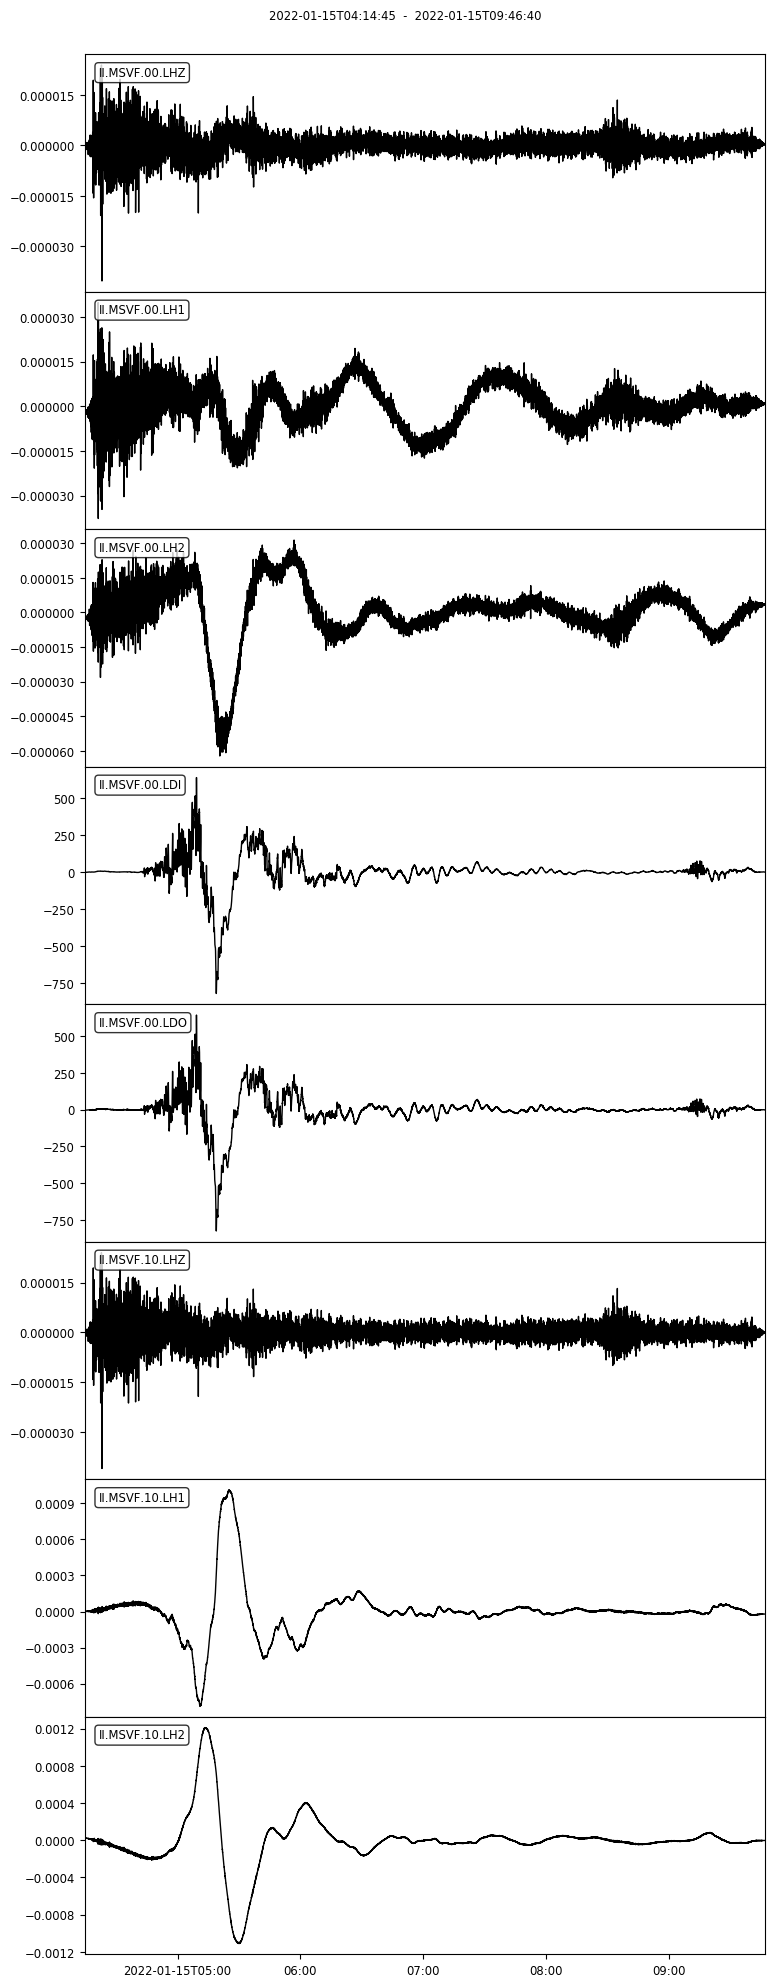

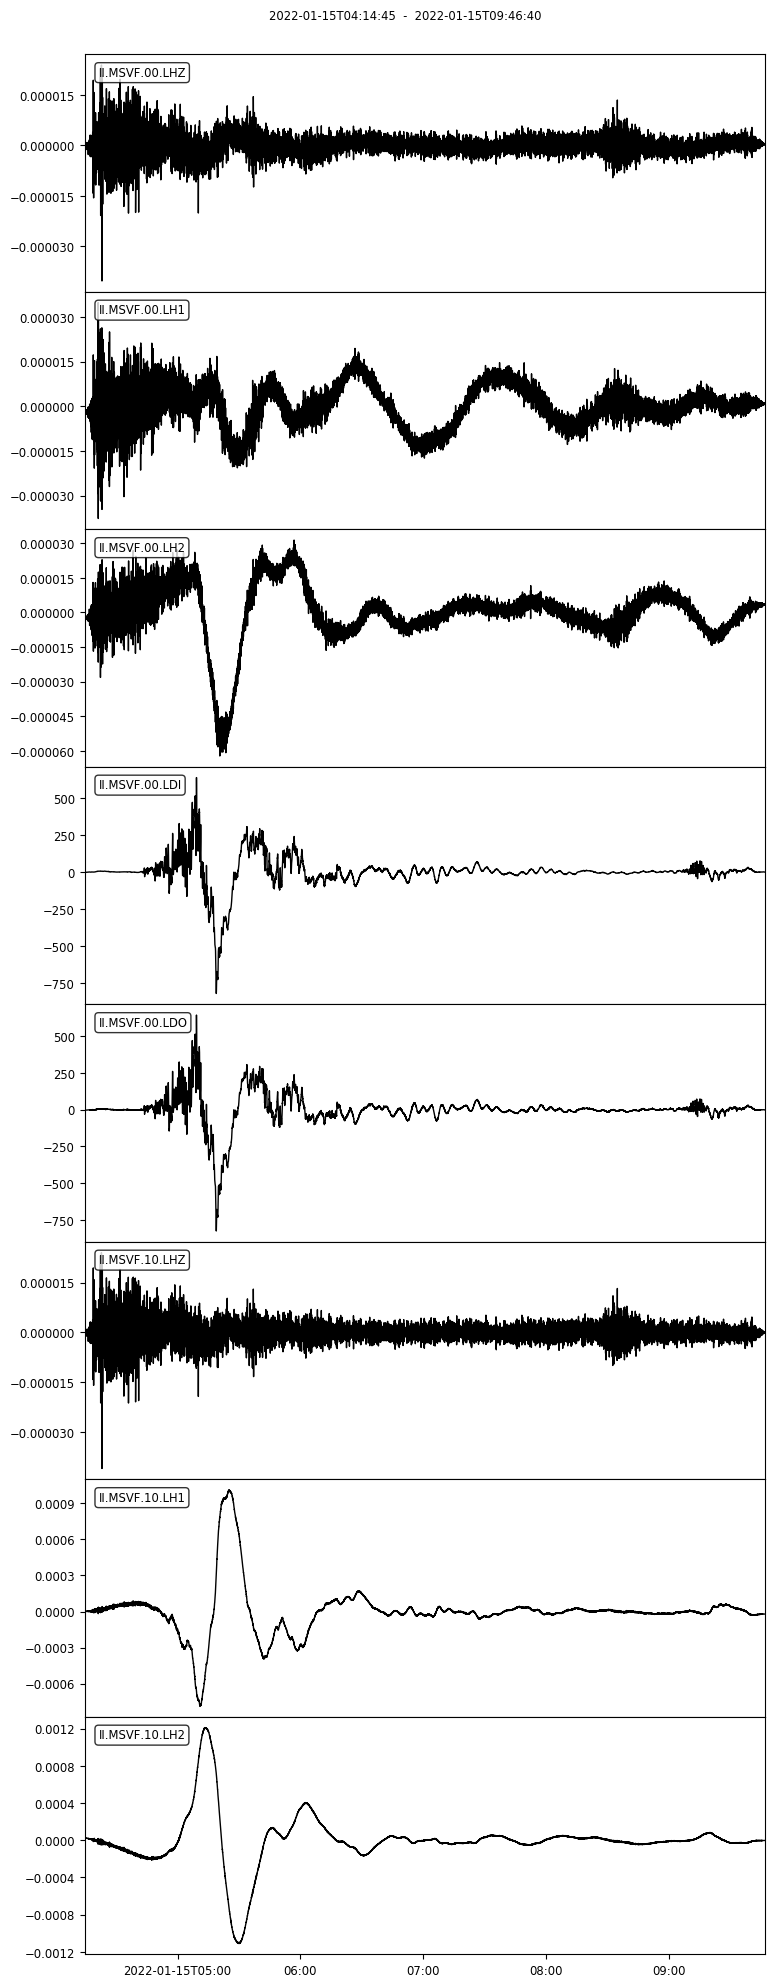

In [7]:
from metrics import compute_stationEnergy, Eacoustic_Boatwright, Eseismic_Boatwright, VASR
st = msvf.copy().select(channel='L[DH]?')
pre_filt = [0.0001, 0.0002, 0.5, 1.0]
inv = fdsnClient.get_stations(
    network = st[0].stats.network,
    station = st[0].stats.station,
    channel = '*',
    starttime = startt,
    endtime = endt,
    level = 'response'
)
attach_station_coordinates_from_inventory(inv, st)
attach_distance_to_stream(st, olat, olon)
st.detrend('linear')
st.filter('highpass', freq=0.0002, corners=2)
st.trim(starttime=otime, endtime=otime+7*3600)
for tr in st:
    if tr.stats.channel[1]=='H':
        tr.remove_response(inventory=inv, pre_filt=pre_filt, plot=False, water_level=60, output='VEL')
    else:
        tr.remove_response(inventory=inv, pre_filt=pre_filt, plot=False, water_level=60)


    if tr.stats.channel[1]=='D':
        tr.stats['energy'] = Eacoustic_Boatwright(tr, tr.stats.distance, rho_atmos=1.2, c_atmos=340)
        print(tr.id, tr.stats.energy)
    elif tr.stats.channel[1]=='H':
        tr.stats['energy'] = Eseismic_Boatwright(tr, tr.stats.distance, rho_earth=2000, c_earth=2500, S=1.0, A=1.0)
        print(tr.id, tr.stats.energy)

st.plot(equal_scale=False)    